# Open exploration

At policy1 (do nothing except evaculation), run experiments with SOBOL uncertainty sampling (nr scenario = 100).

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing? *(feature scoring & sobol)*
- At timestep=0, how is each municipality influenced by the uncertainty factors? *(sobol analysis)*

*Upstream - A1 (Doesburg), A2 (Contenoever), A3 (Zutphen), A4 (Gorssel), A5 (Deventer) - Downstream*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(5) # assign problem_formulation_id

In [3]:
# policies allow only evacuation
policyEWS = {}
for key in dike_model.levers:
    if 'DaysToThreat' in key.name: # EWS_DaysToThreat
        policyEWS.update({key.name: np.arange(0, 5, 1)})
    else: # DikeIncease and RfR
        policyEWS.update({key.name: np.zeros(5)})
        
policies_to_evaluate = [Policy('policyEWS'+str(i), **policy.to_dict()) 
                        for i, policy in pd.DataFrame.from_dict(policyEWS).iterrows()]

In [4]:
n_scenarios = 50

In [5]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= n_scenarios,
                                            policies = policies_to_evaluate,
                                            uncertainty_sampling='sobol')

save_results(results, './results/sobol_policyEWS_50Scenarios_fullyDisaggregated.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2000 scenarios * 5 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\epa1361_open\MBDM-group-11\final assignment\results\sobol_policyEWS_50Scenarios_fullyDisaggregated.tar.gz


Wall time: 1h 39min 2s


In [6]:
results = load_results(r'./results/sobol_policyEWS_50Scenarios_fullyDisaggregated.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\epa1361_open\MBDM-group-11\final assignment\results\sobol_policyEWS_50Scenarios_fullyDisaggregated.tar.gz


In [9]:
# subset only the uncertainties plus EWSlever
experiments = experiments.filter(regex=r'(wave shape$|Bmax$|pfail$|Brate$|^discount|^EWS)')

experiments.sample(10)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,EWS_DaysToThreat
3543,53.0,297.96875,1.0,0.674316,291.09375,1.0,0.006348,173.28125,1.5,0.502441,63.90625,1.5,0.278809,291.09375,1.0,0.759277,3.5,1.5,1.5,1.0
9682,111.0,187.96875,1.0,0.580566,38.28125,1.5,0.960449,207.96875,1.0,0.265137,42.96875,1.0,0.362793,268.28125,1.5,0.575684,3.5,3.5,2.5,4.0
4438,83.0,127.18750,1.0,0.106445,232.81250,1.0,0.063477,332.81250,1.5,0.778320,109.06250,1.0,0.926758,34.68750,1.0,0.895508,2.5,3.5,1.5,2.0
7809,128.0,340.46875,1.0,0.705566,78.28125,1.5,0.335449,87.96875,1.0,0.640137,242.96875,1.0,0.987793,308.28125,1.5,0.700684,3.5,3.5,1.5,3.0
3971,86.0,280.46875,1.0,0.143066,298.28125,1.5,0.272949,107.96875,1.5,0.327637,73.90625,1.0,0.425293,208.28125,1.0,0.638184,1.5,3.5,1.5,1.0
1814,128.0,340.46875,1.0,0.705566,78.28125,1.5,0.335449,87.96875,1.5,0.640137,242.96875,1.0,0.987793,61.09375,1.5,0.700684,3.5,3.5,1.5,0.0
5188,128.0,77.96875,1.5,0.200684,311.09375,1.5,0.318848,73.28125,1.5,0.939941,243.90625,1.0,0.341309,31.09375,1.5,0.071777,2.5,3.5,1.5,2.0
4610,24.0,210.93750,1.0,0.333008,269.68750,1.0,0.327148,167.81250,1.5,0.403320,67.18750,1.0,0.817383,142.81250,1.5,0.526367,2.5,1.5,2.5,2.0
137,62.0,300.93750,1.0,0.426758,39.68750,1.5,0.795898,237.81250,1.5,0.319336,137.18750,1.0,0.911133,232.81250,1.0,0.620117,2.5,2.5,3.5,0.0
7845,95.0,100.46875,1.5,0.455566,261.09375,1.5,0.585449,167.96875,1.5,0.890137,322.96875,1.0,0.237793,68.28125,1.5,0.450684,3.5,1.5,2.5,3.0


In [48]:
pd.DataFrame.from_dict(outcomes).filter(regex=r'0$').sample(10)

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,A.4_Dike Investment Costs 0,A.4_Expected Number of Deaths 0,A.5_Expected Annual Damage 0,A.5_Dike Investment Costs 0,A.5_Expected Number of Deaths 0,RfR Total Costs 0,Expected Evacuation Costs 0
1123,1.820659e+07,0,0.015858,2.891517e+07,0,0.032762,5.323813e+08,0,1.083437,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.000000
5462,8.375802e+07,0,0.008567,3.068630e+06,0,0.000433,5.846365e+06,0,0.001549,5.674197e+07,0,0.003397,2.249255e+08,0,0.025928,0.0,18089.302800
5982,0.000000e+00,0,0.000000,1.542817e+07,0,0.002138,1.496577e+08,0,0.038180,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,6035.276016
7341,5.413229e+08,0,0.042296,0.000000e+00,0,0.000000,1.609279e+07,0,0.003270,0.000000e+00,0,0.000000,1.743057e+07,0,0.001763,0.0,7539.931877
351,6.811667e+08,0,0.339512,8.886839e+05,0,0.000643,2.990993e+07,0,0.040127,0.000000e+00,0,0.000000,1.274178e+08,0,0.084620,0.0,0.000000
5933,1.901374e+07,0,0.002503,5.324363e+06,0,0.000948,1.874553e+07,0,0.006241,5.441641e+06,0,0.000505,1.478654e+08,0,0.023930,0.0,11297.814735
9010,0.000000e+00,0,0.000000,6.679550e+06,0,0.000758,1.269990e+07,0,0.002697,2.473020e+07,0,0.001324,0.000000e+00,0,0.000000,0.0,3143.552530
2177,9.520931e+08,0,0.218879,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,2.512513e+06,0,0.000396,0.000000e+00,0,0.000000,0.0,5044.815125
2040,1.213030e+09,0,0.214029,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,4882.531161
7532,1.933666e+07,0,0.002042,2.929536e+07,0,0.004033,5.304923e+06,0,0.001384,1.412665e+07,0,0.000947,0.000000e+00,0,0.000000,0.0,3948.888844


## Feature scoring

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing?

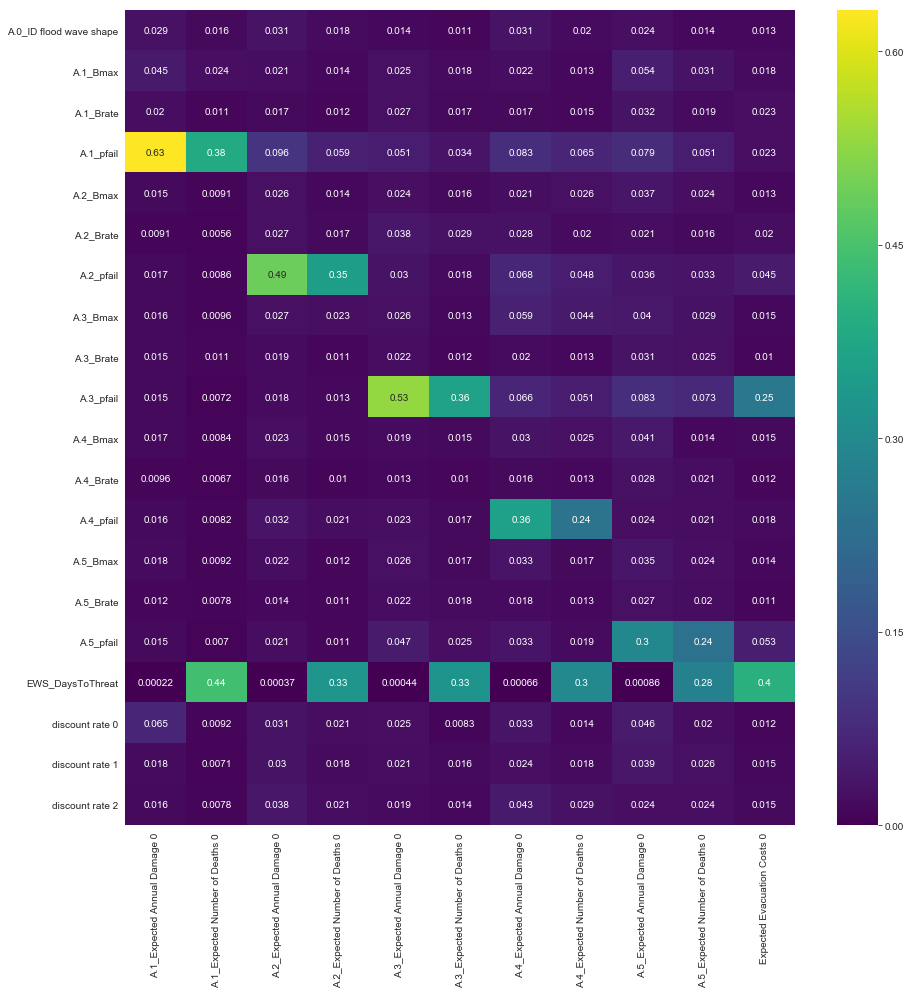

In [42]:
# plot feature scoring at timestep=0
x = experiments
y = pd.DataFrame.from_dict(outcomes).filter(regex=r'0$') # subset only timestep=1
y = y.filter(regex=r'(A.._Expected|Expected Evacuation)') # filter relevant outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(fs, cmap='viridis', annot=True)

## Sobol

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing?
- At timestep=0, how is each municipality influenced by the uncertainty factors? 

In [43]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

problem = get_SALib_problem(dike_model.uncertainties)

In [50]:
def plot_per_municipality_timestep0(KPI, aggregated=False):
    # plot assigned outcome KPI for all five municipalities
    fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True)
    fig.suptitle('Sobol score: Uncertainties on {} at timestep=0 per municipality'.format(KPI),
                 fontsize = 'x-large', y=0.93)

    for i in range(0, 5):
        KPI_i = 'A.{}_{} 0'.format(i+1, KPI) # assign the outcome kpi in interest    

        Si = sobol.analyze(problem, outcomes[KPI_i], 
                           calc_second_order=True, print_to_console=False)

        Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter, index=problem['names'])

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=axes[i], figsize=(12, 8), grid=True)
        axes[i].set_ylabel('A.{}'.format(i+1),
                           fontsize = 'large')
    fig.align_ylabels()

In [51]:
def plot_pfail_per_municipality_timestep0(KPI):
    # plot assigned outcome KPI for all five municipalities, looking only at pfail
    fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True)
    fig.suptitle('Sobol score: pfail on {} at timestep=0 per municipality'.format(KPI),
                 fontsize = 'x-large', y=0.93)

    for i in range(0, 5):
        KPI_i = 'A.{}_{} 0'.format(i+1, KPI) # assign the outcome kpi in interest

        Si = sobol.analyze(problem, outcomes[KPI_i], 
                           calc_second_order=True, print_to_console=False)

        Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter, index=problem['names']).filter(regex='pfail$', axis=0)

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=axes[i], figsize=(8, 8), grid=True)
        axes[i].set_ylabel('A.{}'.format(i+1),
                           fontsize = 'large')
    fig.align_ylabels()

### Expected Evaculation Costs

In [ ]:
KPI = 'Expected Evacuation Costs'

Si = sobol.analyze(problem, outcomes[KPI_i], 
                   calc_second_order=True, print_to_console=False)

### Expected Annual Damage

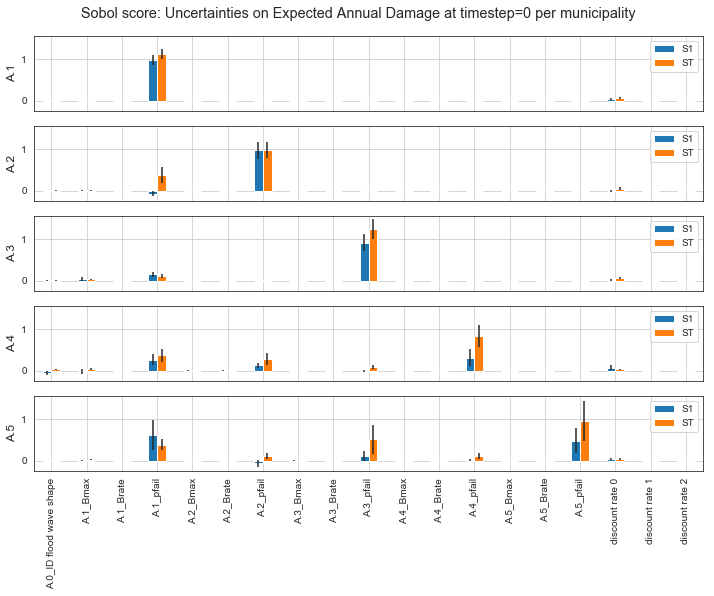

In [52]:
# plot `Expected Annual Damage` at timestep=0 for all five municipalities
plot_per_municipality_timestep0('Expected Annual Damage')

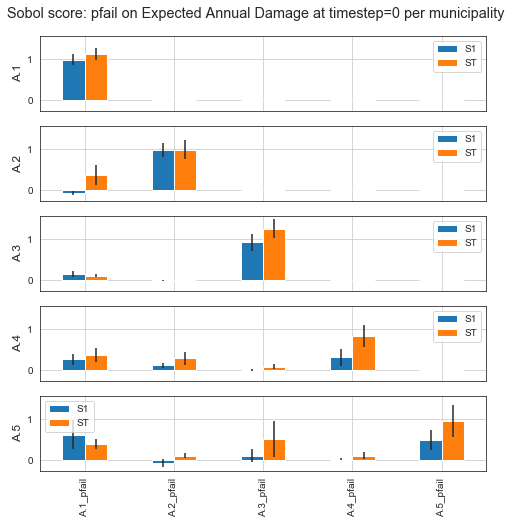

In [53]:
# subset only pfail
plot_pfail_per_municipality_timestep0('Expected Annual Damage')

### Expected Number of Death

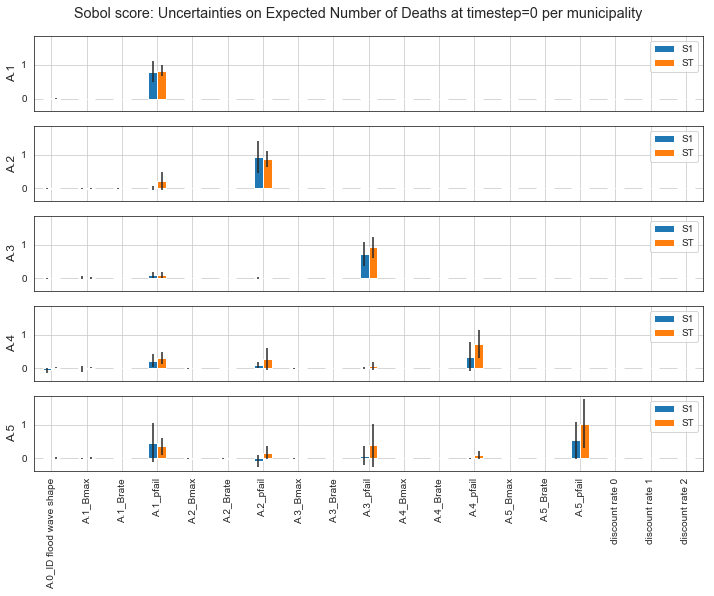

In [54]:
# plot `Expected Number of Deaths` at timestep=0 for all five municipalities
plot_per_municipality_timestep0('Expected Number of Deaths')

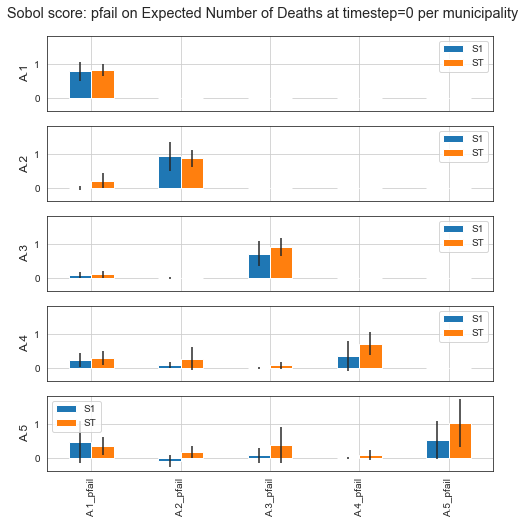

In [55]:
# subset only pfail
plot_pfail_per_municipality_timestep0('Expected Number of Deaths')